In [1]:
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# See the LICENSE file for more details.

In [2]:
import matplotlib.pyplot as plt 
import numpy as np
import tensorflow as tf
import os
import imageio
from tqdm.notebook import tqdm as tqdm

In [3]:
INPUT_X = 56 
INPUT_Y = 46
INPUT_C = 1

In [4]:
NUM_CLASSES = 4

In [5]:
# Change this to the directory you extracted the AT&T Database of Faces archive into
data_dir = 'att_faces/'

In [6]:
face_list = []
label_list = []

for (d,label) in zip(os.listdir(data_dir),range(40)):
    for f in os.listdir(os.path.join(data_dir, d)):
        img = np.stack([imageio.imread(os.path.join(data_dir, d, f)) / 255.0], axis=-1)
        face_list.append(img)
        label_list.append(label)
    label += 1

faces = np.stack(face_list)
labels = np.stack(label_list)

In [7]:
faces = faces[:,::2,::2,:]

indices = [0,28,3,39]
if len(indices) != NUM_CLASSES:
    indices = range(NUM_CLASSES)

faces = np.concatenate([faces[labels==i] for i in indices])
labels = np.concatenate([labels[labels==i] for i in range(NUM_CLASSES)])

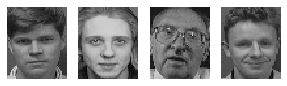

In [8]:
plt.figure(figsize=(10,10))
for i in range(NUM_CLASSES):
    plt.subplot(5,8,i+1)
    img = faces[labels==i][4,:,:,0]
    plt.imshow(np.stack([img,img,img],axis=-1))
    plt.axis('off')
plt.show()

In [9]:
def logit_sparse_categorical_crossentropy(y_true, y_pred):
    return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(INPUT_X, INPUT_Y, INPUT_C)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1000, activation='sigmoid'),
    tf.keras.layers.Dense(300, activation='sigmoid'),
    tf.keras.layers.Dense(NUM_CLASSES, activation=None)
])

model.compile(optimizer='adam',
              loss=logit_sparse_categorical_crossentropy)

In [11]:
model.fit(faces, labels,
         epochs=150,
         batch_size=32,
         verbose=0
         )

In [12]:
def filter_indices(a, classes):
    if not classes:
        return np.repeat(True, a.shape[0])

    return np.all([a != cl for cl in classes], axis=0)

In [13]:
ps = model.predict(faces)

In [14]:
import filtration

In [15]:
normalization_models = [
    filtration.make_filtered_model(model,faces,labels,NUM_CLASSES, [i], mode='normalization',lin_index=-1,apply_softmax=False)
    for i in range(NUM_CLASSES)
]

naive_models = [
    filtration.make_filtered_model(model,faces,labels,NUM_CLASSES, [i], mode='naive',lin_index=-1,apply_softmax=False)
    for i in range(NUM_CLASSES)
]

In [16]:
def calculate_loss_gradient(image, label, filter_class = -1, mode='normalization', guessed_logit=1):
  with tf.GradientTape() as tape:
    tape.watch(image)
    prediction = None
    if filter_class == -1:
        prediction = model(image)
    else:
        m = normalization_models[filter_class] if mode == 'normalization' else naive_models[filter_class]
        prediction = m(image)
        prediction = tf.stack([prediction[:,i] for i in range(0,filter_class)] +
                              [tf.ones(1) * guessed_logit] +
                              [prediction[:,i] for i in range(filter_class,NUM_CLASSES-1)],axis=-1)
    loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction,from_logits=True)

  gradient = tape.gradient(loss, image)

  return gradient


In [17]:
step = .3
iterations = 50

In [18]:
def reconstruct(mode):
    images = np.zeros([NUM_CLASSES+1, NUM_CLASSES, INPUT_X, INPUT_Y])

    for c in tqdm(range(-1,NUM_CLASSES)):
        for i in range(NUM_CLASSES):
            image = tf.zeros([1,INPUT_X,INPUT_Y,INPUT_C]) + .5
            label = i

            for _ in range(iterations):
                perturbations = calculate_loss_gradient(image, label, filter_class = c, mode=mode)
                image -= perturbations * step
                image = tf.clip_by_value(image,0,1)

            image = image[0,:,:,0]
            images[c+1,i] = image
    return images

In [19]:
images = reconstruct(mode = 'normalization')
images2 = reconstruct(mode = 'naive')

In [20]:
def make_fig(images, V_GAP=2, H_GAP=2, figsize=(5,5)):
    big_image = np.ones([images.shape[0] * images.shape[2] + (images.shape[0] - 1) * V_GAP, images.shape[1] * images.shape[3] + (images.shape[1] -1) * H_GAP])
    big_image_base = np.zeros(big_image.shape)

    for c in range(images.shape[0]):
        for i in range(images.shape[1]):
            x = c * INPUT_X + V_GAP * c
            y = i * INPUT_Y + H_GAP * i
            big_image[x:x+INPUT_X, y:y+INPUT_Y] = (images[c,i] - np.min(images[c,i])) / (np.max(images[c,i]) - np.min(images[c,i]))


    plt.figure(figsize=figsize)
    plt.imshow(big_image, cmap='gray')
    plt.axis('off')
    plt.show()

In [21]:
def plot(images):
    images_ = np.zeros([2+NUM_CLASSES,NUM_CLASSES,INPUT_X,INPUT_Y])
    for c in range(NUM_CLASSES):
        images_[0,c] = faces[labels==c][4,:,:,0]

    images_[1:] = images

    make_fig(images_, H_GAP=6, V_GAP=6, figsize=(8,8))

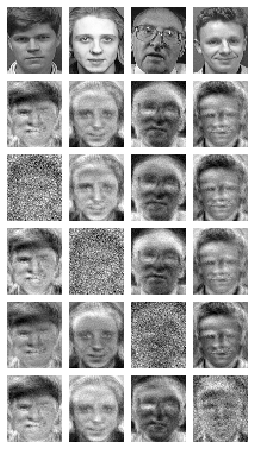

In [22]:
plot(images)

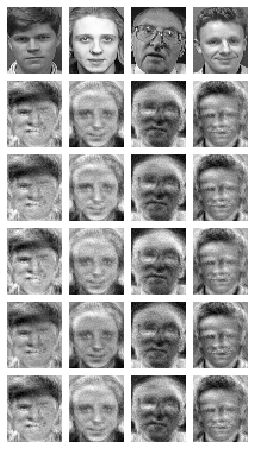

In [23]:
plot(images2)